In [15]:
import numpy as np
import pandas as pd
import glob
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization, Layer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load and Preprocess Data

In [16]:
def load_data_from_psv(folder_path):
    """Load all .psv files and concatenate into a single DataFrame."""
    all_files = glob.glob(os.path.join(folder_path, '*.psv'))
    data_list = []
    for file in all_files:
        df = pd.read_csv(file, sep='|')
        data_list.append(df)
    return pd.concat(data_list, ignore_index=True)

data_folder = r'C:\Users\User\Desktop\LSTM_GenAI\trainingA'
data = load_data_from_psv(data_folder)

# Step 2: Handle Missing Values

In [17]:
def preprocess_data(df):
    """Preprocess the data: handle missing values and normalize."""
    # Fill missing values (forward fill, then backward fill as fallback)
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    # Normalize continuous features
    scaler = StandardScaler()
    continuous_features = [col for col in df.columns if col != 'SepsisLabel' and df[col].dtype in [np.float64, np.int64]]
    df[continuous_features] = scaler.fit_transform(df[continuous_features])

    return df, continuous_features

# Preprocess the data
data, feature_columns = preprocess_data(data)

C:\Users\User\AppData\Local\Temp\ipykernel_18860\1711906078.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18860\1711906078.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
c:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**

# Step 3: Prepare Data for LSTM

In [18]:
def create_sequences_optimized(df, features, target, seq_length):
    """Efficiently create sequences of data for LSTM input."""
    data_array = df[features].values  # Convert to NumPy array
    target_array = df[target].values  # Convert target to NumPy array

    # Ensure sufficient data for sequences
    if len(data_array) <= seq_length:
        raise ValueError("Data length must be greater than the sequence length.")

    num_samples = len(data_array) - seq_length + 1  # Total sequences
    X = np.lib.stride_tricks.sliding_window_view(data_array, (seq_length, len(features)))
    X = X.reshape(num_samples, seq_length, len(features))  # Adjust shape

    y = target_array[seq_length - 1:]  # Align target labels

    return X, y

# Define sequence length and prepare data
sequence_length = 10
X, y = create_sequences_optimized(data, feature_columns, 'SepsisLabel', sequence_length)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Step 4: Build LSTM Model

In [19]:
def build_lstm_model(input_shape):
    """Build and compile an LSTM model."""
    model = Sequential([
        Input(shape=input_shape),
        LSTM(128, return_sequences=True, activation='tanh'),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(64, activation='tanh'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build the model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)

# Step 5: Train the Model

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/20
 145/8643 ━━━━━━━━━━━━━━━━━━━━ 2:45 19ms/step - accuracy: 0.9773 - loss: 0.1086

KeyboardInterrupt: 

# Step 6: Evaluate the Model

In [ ]:
def evaluate_model(model, X_test, y_test):
    """Evaluate the LSTM model."""
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

evaluate_model(model, X_test, y_test)

3705/3705 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9785 - loss: 0.1040
Test Loss: 0.10451771318912506, Test Accuracy: 0.97831791639328


# Step 7: Optimize Classification Threshold

In [8]:
preds = model.predict(X_val)
precision, recall, thresholds = precision_recall_curve(y_val, preds)
optimal_threshold = thresholds[np.argmax(precision * recall)]
print(f"Optimal Threshold: {optimal_threshold}")

3705/3705 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
Optimal Threshold: 0.0219611506909132


# Step 8: Save the Model

In [9]:
model.save('optimized_sepsis_lstm_model.h5')

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Lambda, Layer

In [11]:
# Build Variational Autoencoder (VAE)

# Define VAE Encoder
def build_vae_encoder(input_dim, latent_dim):
    inputs = Input(shape=(input_dim,))
    h = Dense(64, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(h)
    z_log_var = Dense(latent_dim, name='z_log_var')(h)
    return Model(inputs, [z_mean, z_log_var], name="encoder"), inputs

# Define Sampling Layer
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Define VAE Decoder
def build_vae_decoder(latent_dim, output_dim):
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(64, activation='relu')(latent_inputs)
    outputs = Dense(output_dim, activation='sigmoid')(x)
    return Model(latent_inputs, outputs, name="decoder")



In [12]:

# VAE Loss Layer Integration
class VAELossLayer(Layer):
    def call(self, inputs):
        vae_inputs, vae_outputs, z_mean, z_log_var = inputs
        # Reconstruction Loss
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(tf.square(vae_inputs - vae_outputs), axis=-1)
        )
        # KL Divergence Loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        )
        total_loss = reconstruction_loss + kl_loss
        self.add_loss(total_loss)
        return vae_outputs  # Pass outputs for further us



In [25]:
# Replace VAE Model Definition
# HR, O2Sat, Temp, SBP, MAP, DBP, Resp, EtCO2, BaseExcess, HCO3, FiO2, pH, PaCO2, SaO2, AST, BUN, Alkalinephos, Calcium, Chloride, Creatinine, Bilirubin_direct, Glucose, Lactate, Magnesium, Phosphate, Potassium, Bilirubin_total, TroponinI, Hct, Hgb, PTT, WBC, Fibrinogen, Platelets, Age, Gender, Unit1, Unit2, HospAdmTime, ICULOS, SepsisLabel
# 41 features(SpesisLabel is result so 40 features)

vae_input_dim = 40  # Exclude 'SepsisLabel'

# Define the encoder and decoder models
latent_dim = 10  # Example latent dimension, can be adjusted as needed
encoder, encoder_inputs = build_vae_encoder(input_dim=vae_input_dim, latent_dim=latent_dim)
decoder = build_vae_decoder(latent_dim=latent_dim, output_dim=vae_input_dim)

# Replace VAE Model Definition
vae_inputs_layer = Input(shape=(vae_input_dim,))
vae_encoder_outputs = encoder(vae_inputs_layer)
z_mean, z_log_var = vae_encoder_outputs
z = Sampling()([z_mean, z_log_var])
vae_decoder_outputs = decoder(z)

In [24]:
# Add Loss Computation Layer
vae_outputs = VAELossLayer()([vae_inputs_layer, vae_decoder_outputs, z_mean, z_log_var])

# Final VAE Model
vae = Model(vae_inputs_layer, vae_outputs, name='vae')

In [29]:
# Compile and Train the VAE
vae.compile(optimizer='adam')
vae.fit(X_train[:, -1, :], X_train[:, -1, :], epochs=50, batch_size=64, validation_data=(X_val[:, -1, :], X_val[:, -1, :]))


Epoch 1/50
8643/8643 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: nan - val_loss: nan
Epoch 2/50
8643/8643 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: nan - val_loss: nan
Epoch 3/50
8643/8643 ━━━━━━━━━━━━━━━━━━━━ 85s 5ms/step - loss: nan - val_loss: nan
Epoch 4/50
8643/8643 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: nan - val_loss: nan
Epoch 5/50
8643/8643 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: nan - val_loss: nan
Epoch 6/50
8643/8643 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: nan - val_loss: nan
Epoch 7/50
8643/8643 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: nan - val_loss: nan
Epoch 8/50
8643/8643 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: nan - val_loss: nan
Epoch 9/50
8643/8643 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: nan - val_loss: nan
Epoch 10/50
8643/8643 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: nan - val_loss: nan
Epoch 11/50
8643/8643 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: nan - val_loss: nan
Epoch 12/50
8643/8643 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: nan - val_loss: nan
E

KeyboardInterrupt: 

In [41]:
# Generate Personalized Recommendations
def generate_recommendations(vae, patient_data):
    """Generate personalized recommendations using the VAE model."""
    synthetic_pathway = vae.predict(patient_data)
    recommendations = []
    for pathway in synthetic_pathway:
        if pathway.mean() > 0.5:  # Example condition for recommendations
            recommendations.append("Recommend aggressive intervention.")
        else:
            recommendations.append("Recommend close monitoring.")
    return recommendations

In [40]:
# Example Usage with LSTM + VAE
patient_data = X_test[:, -1, :]
recommendations = generate_recommendations(vae, patient_data)
for i, rec in enumerate(recommendations[:10]):
    print(f"Patient {i + 1}: {rec}")

3705/3705 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
Patient 1: Recommend close monitoring.
Patient 2: Recommend close monitoring.
Patient 3: Recommend close monitoring.
Patient 4: Recommend close monitoring.
Patient 5: Recommend close monitoring.
Patient 6: Recommend close monitoring.
Patient 7: Recommend close monitoring.
Patient 8: Recommend close monitoring.
Patient 9: Recommend close monitoring.
Patient 10: Recommend close monitoring.


In [36]:
def plot_precision_recall(y_true, y_pred):
    """Plot precision-recall curve."""
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.show()

def plot_roc_curve(y_true, y_pred):
    """Plot ROC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def plot_training_history(history):
    """Plot training and validation loss and accuracy."""
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()







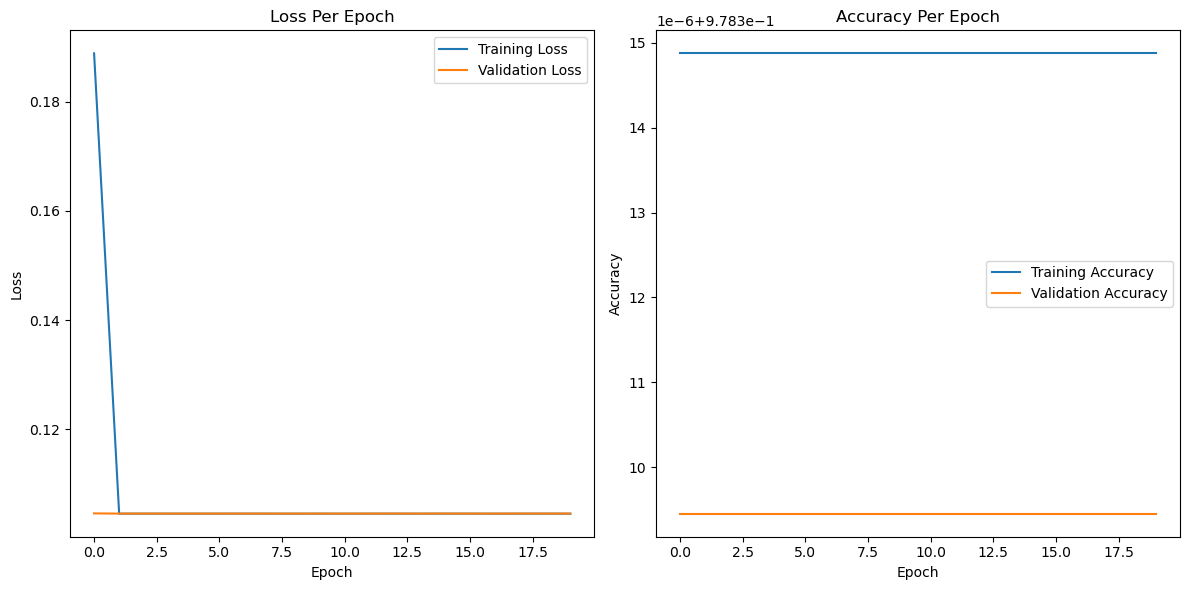

In [37]:
# Plot LSTM Training History
plot_training_history(history)

3705/3705 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step


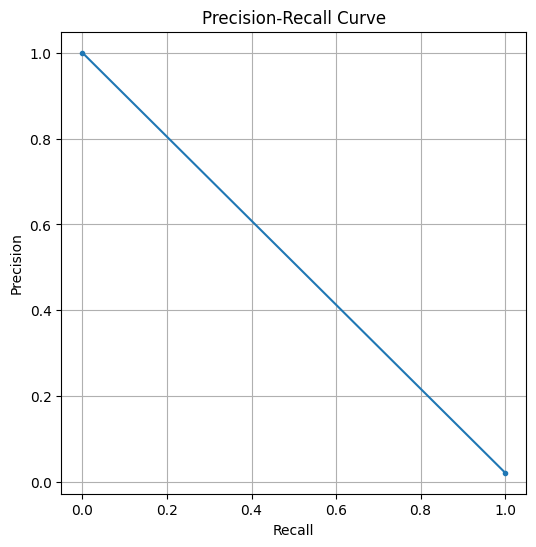

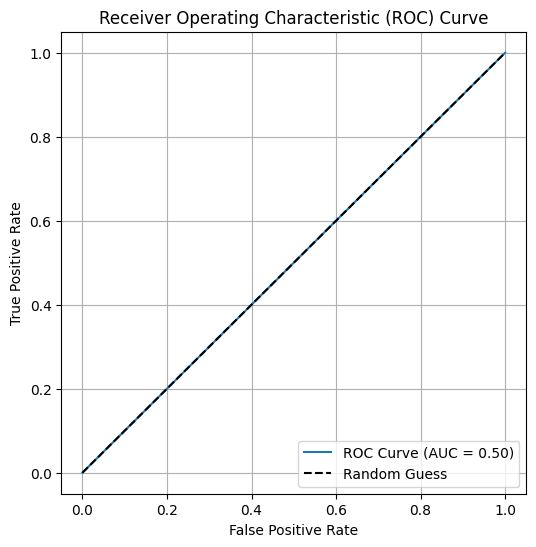

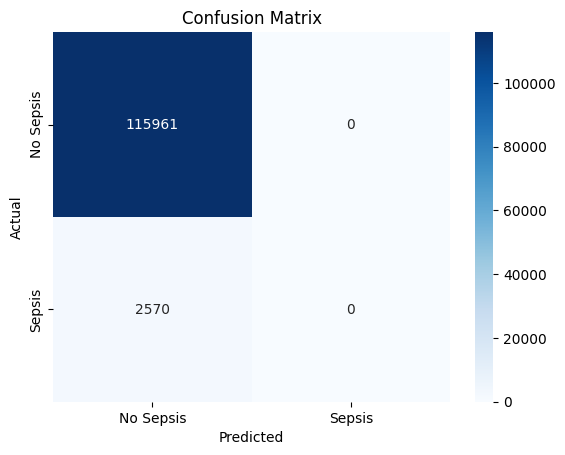

Classification Report:
              precision    recall  f1-score   support

   No Sepsis       0.98      1.00      0.99    115961
      Sepsis       0.00      0.00      0.00      2570

    accuracy                           0.98    118531
   macro avg       0.49      0.50      0.49    118531
weighted avg       0.96      0.98      0.97    118531



c:\Users\uSER\anaconda3\envs\aaa_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\uSER\anaconda3\envs\aaa_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\uSER\anaconda3\envs\aaa_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
# Step 2: Additional Metrics
def plot_confusion_matrix(y_true, y_pred, threshold=0.5):
    """Plot confusion matrix."""
    y_pred_class = (y_pred >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred_class)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Sepsis', 'Sepsis'], yticklabels=['No Sepsis', 'Sepsis'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def print_classification_report(y_true, y_pred, threshold=0.5):
    """Print classification report."""
    y_pred_class = (y_pred >= threshold).astype(int)
    print("Classification Report:")
    print(classification_report(y_true, y_pred_class, target_names=['No Sepsis', 'Sepsis']))

# Step 3: Evaluation
# Predict probabilities for the test set
y_pred_prob = model.predict(X_test).flatten()

# Precision-Recall and ROC Curve
plot_precision_recall(y_test, y_pred_prob)
plot_roc_curve(y_test, y_pred_prob)

# Confusion Matrix and Classification Report
plot_confusion_matrix(y_test, y_pred_prob)
print_classification_report(y_test, y_pred_prob)

3705/3705 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


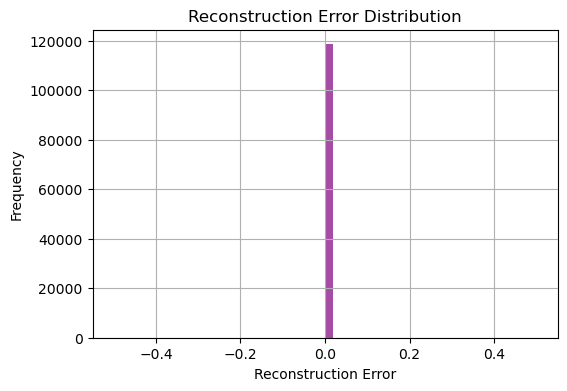

3705/3705 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
Patient 1: Recommend close monitoring.
Patient 2: Recommend close monitoring.
Patient 3: Recommend close monitoring.
Patient 4: Recommend close monitoring.
Patient 5: Recommend close monitoring.
Patient 6: Recommend close monitoring.
Patient 7: Recommend close monitoring.
Patient 8: Recommend close monitoring.
Patient 9: Recommend close monitoring.
Patient 10: Recommend close monitoring.


In [42]:
# Step 4: Generative AI Metrics
def plot_reconstruction_error(original, reconstructed):
    """Compute and plot reconstruction error."""

    reconstruction_error = np.mean(np.square(original - reconstructed), axis=-1)
    reconstruction_error = np.nan_to_num(reconstruction_error)  # Replace NaN values with zero
    plt.figure(figsize=(6, 4))
    plt.hist(reconstruction_error, bins=50, alpha=0.7, color='purple')
    plt.title('Reconstruction Error Distribution')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


# Evaluate VAE Reconstruction Error
reconstructed_data = vae.predict(X_test[:, -1, :])
plot_reconstruction_error(X_test[:, -1, :], reconstructed_data)

# Generate Recommendations
recommendations = generate_recommendations(vae, X_test[:, -1, :])

for i, rec in enumerate(recommendations[:10]):
    print(f"Patient {i + 1}: {rec}")
